# 1. Data Load


In [1]:
import numpy as np
import pandas as pd
import math

from scipy import stats #Analysis 
from scipy.stats import norm 

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [2]:
path = "./Dataset/"

data = pd.read_csv(path+"kwproja_data_location.csv")
#data = pd.read_csv('../input/dolphin-kwproja-bigdata/kwproja_data_big.csv')

# original data -> data
data

,DATE_,SHOP_CODE,SHOP_NAME,SHOP_TYPE_BIG,SHOP_TYPE_SMALL,LONGITUDE,LATITUDE,MONTHLY_GAIN,AVERAGE_SALE_PRICE,GU,DONG
0,201709,45141160116,하누소(서강점),한식,고기구이/육회 전문점,126.931554,37.549088,1.611684e+08,52223,용산구,남영동
1,201706,5471200405,라온,한식,고기구이/육회 전문점,126.899687,37.482303,1.044239e+07,54803,중구,광희동
2,201706,16462120411,임짱서서갈비,한식,고기구이/육회 전문점,127.121116,37.529048,2.083761e+07,52700,용산구,용문동
3,201706,87190510210,마포숯불갈비,한식,고기구이/육회 전문점,127.082682,37.648073,1.956376e+07,50900,금천구,가산동
4,201708,87940250216,엄가네식당,한식,고기구이/육회 전문점,127.077226,37.611817,1.950926e+07,50386,광진구,화양동
...,...,...,...,...,...,...,...,...,...,...,...
2927734,201803,66340980106,최가네 남원추어탕,수산물,회/수산물 일반,126.963825,37.526863,1.369377e+07,21511,강남구,도곡2동
2927735,201803,7211800169,우미도라꾸,수산물,회/수산물 일반,127.070132,37.536551,1.743280e+07,74559,노원구,상계6.7동
2927736,201804,7408500552,연안해물칼국수 행당점,수산물,회/수산물 일반,127.033712,37.559118,1.702310e+07,34212,양천구,목2동
2927737,201803,36412610212,동해수산,수산물,회/수산물 일반,127.127448,37.537151,3.153391e+07,52973,은평구,응암3동


# 2. EDA 

2,927,739 rows X 11 columns

- 매장 속성 정보
  - shop_code -> 식별자 feature => drop   
  - shop_name => DL
  - longtitude : 경도, latitude : 위도 -> 매장 위치 (회사 근처, 학교 근처 등 매출 영향성 있음) -> K-mean clustering => geo, ML, DL
  - address1, address2 : GeoEncoder를 통해 따로 얻은 행정동, 1(30), 2(436) => DL
  - shop_type_big -> 15 category, shop_type_big_label, ML => DL
  - shop_type_small -> 61 category, shop_type_small_label, ML => DL 

- 매출 정보
  - date -> 24 category, 201606~ 201805 까지의 data
  - monthly_gain / avearge_sale_price = 한달 총 판매수

- 매출 통계 정보-> X

In [5]:
# rename data columns and check the data
data.columns = ['date', 'shop_code', 'shop_name', 'shop_type_big', 'shop_type_small', 
                'longitude', 'latitude', 'monthly_gain', 'average_sale_price', 'address1', 'address2']

print(data.columns, '\n')
print(data.info())

Index(['date', 'shop_code', 'shop_name', 'shop_type_big', 'shop_type_small',
       'longitude', 'latitude', 'monthly_gain', 'average_sale_price',
       'address1', 'address2'],
      dtype='object') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2927739 entries, 0 to 2927738
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date                int64  
 1   shop_code           int64  
 2   shop_name           object 
 3   shop_type_big       object 
 4   shop_type_small     object 
 5   longitude           float64
 6   latitude            float64
 7   monthly_gain        float64
 8   average_sale_price  int64  
 9   address1            object 
 10  address2            object 
dtypes: float64(3), int64(3), object(5)
memory usage: 245.7+ MB
None


# 3. Preprocessing
data -> processed_data
- 9 columns : **shop_code | date | shop_name | shop_type_big | shop_type_small | longitude | latitude | average_sale_price | monthly_gain**
- shop_code : 식별자 feature 이므로 drop 
- date : 아직은 쓸 수 없으므로 drop
- missing value 제거 : A/N
- shop_type_big(15), shop_type_small(61) 
    - ML : label encodding
    - DL : NLP
- longitude, latitude : 
    - ML : k-mean clustering -> geo column 
    - DL : NLP, reverse geo encoder(행정동, 법정동, 지번주소, 도로명주소) -> 지번주소 가져오세요(for web) 
    - 행정동admcode, 법정동legalcode -> area1, area2, area3, area4
    - 지번 주소addr -> area1, area2, area3, area4 (x), land -> namber1, number2
    - 도로명 주소roadaddr -> area1, area2, area3, area4(x), land -> number1, number2, name  
- average_sale_price 
    - log transformation 
- MinMaxSaclar 정규화 -> 정규화 column의 범위는?? 실험필요 요인 

In [11]:
# 원본 data와 따로 관리 -> original data = data, preprocessed data = processed_data 
# feature drop : date, shop_code
processed_data = data.drop(['date', 'shop_code'], axis=1).copy()

In [12]:
# There are no missing values 
# missing value drop - monthly_gain
null_index = processed_data[processed_data['monthly_gain']==0].index 
print("monthly gain null : ", len(null_index))
processed_data = processed_data.drop(null_index)

# missing value drop - average_sale_price
null_index = processed_data[processed_data['average_sale_price']==0].index 
print("average sale price null : ", len(null_index))
processed_data = processed_data.drop(null_index)

# missing value drop - shop_type_big
null_index = processed_data[processed_data['shop_type_big'].isnull()==True].index
print("shop type big null : ", len(null_index))
print("shop type big unique : ", processed_data['shop_type_big'].nunique())
processed_data = processed_data.drop(null_index)

# missing value drop - shop_type_small 
null_index = processed_data[processed_data['address1'].isnull()==True].index
print("shop type small null : ", len(null_index))
print("shop type small unique : ", processed_data['address1'].nunique() )

monthly gain null :  0
average sale price null :  0
shop type big null :  0
shop type big unique :  15
shop type small null :  0
shop type small unique :  30


In [13]:
# LabelEncoder
from sklearn.preprocessing import LabelEncoder

# fit transform으로 한번에 처리 가능
le = LabelEncoder()
processed_data['shop_type_big_label'] = le.fit_transform(list(processed_data['shop_type_big']))   
print(le.classes_)

le = LabelEncoder()
processed_data['shop_type_small_label'] = le.fit_transform(list(processed_data['shop_type_small'])) 
print(le.classes_)

['다방/커피숍/카페' '별식/퓨전요리' '분식' '뷔페' '생활서비스' '소매' '수산물' '양식' '유흥주점' '음식-미분류'
 '일식' '제과제빵떡케익' '중식' '패스트푸드' '한식']
['고기 뷔페' '고기구이/육회 전문점' '곱창/양구이 전문점' '구내식당' '국수/수제비 전문점' '기타세계요리 전문점'
 '낙지/문어/오징어/쭈꾸미 전문점' '냉면 전문점' '덮밥/가정식' '도너츠/꽈배기/고로케/호떡 전문점'
 '도시락/컵밥/주먹밥/배달음식 전문점' '돈가스 전문점' '떡/한과 전문점' '마라/양꼬치/훠궈 전문점' '면 전문점'
 '미분류 유흥업소' '민속주점' '바닷가재/게요리 전문점' '반찬 판매' '백화점' '버거 전문점' '베트남음식 전문점'
 '보쌈/족발 전문점' '분식 전문점' '샌드위치/토스트/핫도그 전문점' '샤브샤브 전문점' '세탁소' '소주방/포장마차'
 '순대 전문점' '슈퍼/잡화/할인매장' '스테이크 전문점' '식료품' '아이스크림/빙수 판매' '오리/닭요리 전문점'
 '오리/닭요리/탕/백숙 전문점' '와인/칵테일/위스키 바' '음식-미분류' '이자까야/꼬치구이' '이태리 전문점'
 '인도음식 전문점' '일반 중식당' '장어 전문점' '전통찻집' '제과/제빵 전문점' '조개 전문점' '종합 뷔페'
 '죽요리 전문점' '참치 전문점' '초밥 전문점' '치킨/닭강정 전문점' '카레 전문점' '카페/디저트' '테이크아웃 음료 전문점'
 '편의점' '퓨전음식 전문점' '피자 전문점' '한식국물요리 전문점' '한정식/백반 전문점' '호프/맥주' '화로구이 전문점'
 '회/수산물 일반']


In [14]:
# BinaryEncoder for categorical variable 
import category_encoders as ce

encoder = ce.BinaryEncoder(cols=["shop_type_big", "shop_type_small"])
df = encoder.fit_transform(processed_data[["shop_type_big", "shop_type_small"]])

processed_data = pd.concat([processed_data, df], axis=1)

C:\Users\mtang\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [15]:
# NLP용 preprocessing 
# shop_name, shop_type_big, shop_type_small = concat_text 
processed_data['text'] = processed_data['shop_name'] + ' ' + processed_data['shop_type_big'] + ' ' + processed_data['shop_type_small']
processed_data['address'] = processed_data['address1'] + ' ' + processed_data['address2']
processed_data['concat_text'] = processed_data['text'] + ' ' + processed_data['address']
processed_data = processed_data.drop(['text', 'shop_name', 'shop_type_big', 'shop_type_small', 'address', 'address1', 'address2'], axis=1)

[[ 37.565614   126.99346358]
 [ 37.49493385 126.89656951]
 [ 37.51705963 127.12108587]
 [ 37.63886394 127.04522966]
 [ 37.57403331 126.92450098]
 [ 37.53991842 126.84565928]
 [ 37.49644037 126.95192735]
 [ 37.57097995 127.06672092]
 [ 37.50143924 127.03451271]]
[4 1 2 ... 7 2 1]


C:\Users\mtang\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


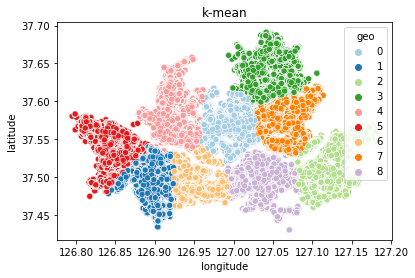

In [17]:
# Labeling - KMeans Clustering 
# longitude + latitude = geo 
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=9).fit(processed_data[['latitude', 'longitude']])
print(kmeans.cluster_centers_)
print(kmeans.labels_)

processed_data['geo'] = kmeans.labels_

# plotting geo
sns.scatterplot(x='longitude' , y='latitude', hue="geo", data=processed_data, palette="Paired")
plt.title('k-mean')

processed_data = processed_data.drop(['longitude', 'latitude'], axis=1)

In [18]:
# average_sale_price -> skewed data 
# log transfromation 
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, Normalizer

scale_cols = ['average_sale_price']
processed_data[scale_cols] = processed_data[scale_cols].apply(lambda x : np.log1p(x))

processed_data

,monthly_gain,average_sale_price,shop_type_big_label,shop_type_small_label,shop_type_big_0,shop_type_big_1,shop_type_big_2,shop_type_big_3,shop_type_big_4,shop_type_small_0,shop_type_small_1,shop_type_small_2,shop_type_small_3,shop_type_small_4,shop_type_small_5,shop_type_small_6,concat_text,geo
0,1.611684e+08,10.863297,14,1,0,0,0,0,1,0,0,0,0,0,0,1,하누소(서강점) 한식 고기구이/육회 전문점 용산구 남영동,4
1,1.044239e+07,10.911518,14,1,0,0,0,0,1,0,0,0,0,0,0,1,라온 한식 고기구이/육회 전문점 중구 광희동,1
2,2.083761e+07,10.872390,14,1,0,0,0,0,1,0,0,0,0,0,0,1,임짱서서갈비 한식 고기구이/육회 전문점 용산구 용문동,2
3,1.956376e+07,10.837638,14,1,0,0,0,0,1,0,0,0,0,0,0,1,마포숯불갈비 한식 고기구이/육회 전문점 금천구 가산동,3
4,1.950926e+07,10.827488,14,1,0,0,0,0,1,0,0,0,0,0,0,1,엄가네식당 한식 고기구이/육회 전문점 광진구 화양동,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2927734,1.369377e+07,9.976366,6,60,0,0,1,0,0,0,1,1,1,1,0,0,최가네 남원추어탕 수산물 회/수산물 일반 강남구 도곡2동,6
2927735,1.743280e+07,11.219359,6,60,0,0,1,0,0,0,1,1,1,1,0,0,우미도라꾸 수산물 회/수산물 일반 노원구 상계6.7동,7
2927736,1.702310e+07,10.440361,6,60,0,0,1,0,0,0,1,1,1,1,0,0,연안해물칼국수 행당점 수산물 회/수산물 일반 양천구 목2동,7
2927737,3.153391e+07,10.877557,6,60,0,0,1,0,0,0,1,1,1,1,0,0,동해수산 수산물 회/수산물 일반 은평구 응암3동,2


# 4. Target Variable Labeling and EDA for variable y
processed_data -> labeled_data 
- 어떻게 라벨링 할 것인가? 
- 1. Classification : use mean, std -> failed
- 2. Classification : Quantile 10%, 20%, 25%, 33% -> label 10, 5, 4, 3 
- 3. Classification : Quantile by shop_type_big with lower fence, Q2, upper_fence -> label 31
- 3. **Classification : Quantile by shop_type_big with Q1, Q2, Q3 -> label 45** 
- 4. Classification : price label, min:5, max:181억 -> label 15
- 5. Removing Outlier : outler 233,140 -> total data(without outlier) 2,694,599
- 6. Rounding data 

In [20]:
# pandas option 설정 하는 코드
# monthly_gain의 경우 부동소수점으로 나타나서 보기 어려울땐 윗 줄의 주석을 제거하고 아래에 주석을 추가하고
# 다시 원래대로 돌리고 싶다면 아래에 주석제거, 위 코드에 주석추가
pd.options.display.float_format = '{:.2f}'.format
#pd.reset_option('display.float_format')

# 전처리된 data와 따로 관리 -> preprocessed data = procssed_data, labeled data = labeled_data 
labeled_data = processed_data.copy()
labeled_data

,monthly_gain,average_sale_price,shop_type_big_label,shop_type_small_label,shop_type_big_0,shop_type_big_1,shop_type_big_2,shop_type_big_3,shop_type_big_4,shop_type_small_0,shop_type_small_1,shop_type_small_2,shop_type_small_3,shop_type_small_4,shop_type_small_5,shop_type_small_6,concat_text,geo
0,161168354.06,10.86,14,1,0,0,0,0,1,0,0,0,0,0,0,1,하누소(서강점) 한식 고기구이/육회 전문점 용산구 남영동,4
1,10442391.67,10.91,14,1,0,0,0,0,1,0,0,0,0,0,0,1,라온 한식 고기구이/육회 전문점 중구 광희동,1
2,20837606.24,10.87,14,1,0,0,0,0,1,0,0,0,0,0,0,1,임짱서서갈비 한식 고기구이/육회 전문점 용산구 용문동,2
3,19563757.17,10.84,14,1,0,0,0,0,1,0,0,0,0,0,0,1,마포숯불갈비 한식 고기구이/육회 전문점 금천구 가산동,3
4,19509264.11,10.83,14,1,0,0,0,0,1,0,0,0,0,0,0,1,엄가네식당 한식 고기구이/육회 전문점 광진구 화양동,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2927734,13693767.90,9.98,6,60,0,0,1,0,0,0,1,1,1,1,0,0,최가네 남원추어탕 수산물 회/수산물 일반 강남구 도곡2동,6
2927735,17432801.29,11.22,6,60,0,0,1,0,0,0,1,1,1,1,0,0,우미도라꾸 수산물 회/수산물 일반 노원구 상계6.7동,7
2927736,17023101.74,10.44,6,60,0,0,1,0,0,0,1,1,1,1,0,0,연안해물칼국수 행당점 수산물 회/수산물 일반 양천구 목2동,7
2927737,31533908.77,10.88,6,60,0,0,1,0,0,0,1,1,1,1,0,0,동해수산 수산물 회/수산물 일반 은평구 응암3동,2


#### Labeling) shop_type_big에 따라 Q1, Q2, Q3, upper fence, lower fence값 이용  

- shop_type_big 당 label 3개 : Total lable 30 + 1(lower_fence=0) = 31 
- Q1 ~ 이하 값 : lower fence = 0
- Q1 ~ Q3 : Q2, mid
- Q3 ~ 이상 값 : upper fence 

- shop_type_big 당 label 3개 : Total label 45
- Q1 이하값 : Q1 
- Q1 ~ Q3 : Q2, mid
- Q3 이상값 : Q3

In [21]:
def get_pricelist(i, data) :
    df = data[['shop_type_big_label','monthly_gain']].groupby('shop_type_big_label')
    Q1 = df.get_group(i)['monthly_gain'].quantile(0.25)
    Q2 = df.get_group(i)['monthly_gain'].quantile(0.5)
    Q3 = df.get_group(i)['monthly_gain'].quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - (1.5 * IQR)
    upper_fence = Q3 + (1.5 * IQR)
    if lower_fence <= 0 : lower_fence = 0
        
    return lower_fence, Q1, Q2, Q3, upper_fence

def labeling(data) : 
    for i in range(0,15) : 
        lower_fence, Q1, Q2, Q3, upper_fence = get_pricelist(i, data)
        prices = data.loc[(data.shop_type_big_label == i), 'monthly_gain']
        #prices = prices.apply(lambda x: lower_fence if x < Q1 else (upper_fence if x > Q3 else Q2))
        prices = prices.apply(lambda x : Q1 if x < Q1 else (Q3 if x > Q3 else Q2))
        data.loc[(data.shop_type_big_label == i), 'gain_label'] = prices
    return data

labeled_data = labeling(labeled_data)
print("label counts: ", labeled_data['gain_label'].nunique())
labeled_data

label counts:  45


,monthly_gain,average_sale_price,shop_type_big_label,shop_type_small_label,shop_type_big_0,shop_type_big_1,shop_type_big_2,shop_type_big_3,shop_type_big_4,shop_type_small_0,shop_type_small_1,shop_type_small_2,shop_type_small_3,shop_type_small_4,shop_type_small_5,shop_type_small_6,concat_text,geo,gain_label
0,161168354.06,10.86,14,1,0,0,0,0,1,0,0,0,0,0,0,1,하누소(서강점) 한식 고기구이/육회 전문점 용산구 남영동,4,30392434.57
1,10442391.67,10.91,14,1,0,0,0,0,1,0,0,0,0,0,0,1,라온 한식 고기구이/육회 전문점 중구 광희동,1,14123414.79
2,20837606.24,10.87,14,1,0,0,0,0,1,0,0,0,0,0,0,1,임짱서서갈비 한식 고기구이/육회 전문점 용산구 용문동,2,14123414.79
3,19563757.17,10.84,14,1,0,0,0,0,1,0,0,0,0,0,0,1,마포숯불갈비 한식 고기구이/육회 전문점 금천구 가산동,3,14123414.79
4,19509264.11,10.83,14,1,0,0,0,0,1,0,0,0,0,0,0,1,엄가네식당 한식 고기구이/육회 전문점 광진구 화양동,3,14123414.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2927734,13693767.90,9.98,6,60,0,0,1,0,0,0,1,1,1,1,0,0,최가네 남원추어탕 수산물 회/수산물 일반 강남구 도곡2동,6,18101518.61
2927735,17432801.29,11.22,6,60,0,0,1,0,0,0,1,1,1,1,0,0,우미도라꾸 수산물 회/수산물 일반 노원구 상계6.7동,7,18101518.61
2927736,17023101.74,10.44,6,60,0,0,1,0,0,0,1,1,1,1,0,0,연안해물칼국수 행당점 수산물 회/수산물 일반 양천구 목2동,7,18101518.61
2927737,31533908.77,10.88,6,60,0,0,1,0,0,0,1,1,1,1,0,0,동해수산 수산물 회/수산물 일반 은평구 응암3동,2,18101518.61


#### Option) Removing outlier
upper fence, lower fence 외 값(outlier)을 제거합니다 
- 2,927,739 x 19   ->   2,694,599 x 19

In [22]:
def get_pricelist(i, data) :
    df = data[['shop_type_big_label','monthly_gain']].groupby('shop_type_big_label')
    Q1 = df.get_group(i)['monthly_gain'].quantile(0.25)
    Q2 = df.get_group(i)['monthly_gain'].quantile(0.5)
    Q3 = df.get_group(i)['monthly_gain'].quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - (1.5 * IQR)
    upper_fence = Q3 + (1.5 * IQR)
    if lower_fence <= 0 : lower_fence = 0
        
    return lower_fence, Q1, Q2, Q3, upper_fence

def remove_outlier(data, processed_data) :
    output_data = data.copy()
    for i in range(0,15) :
        lower_fence, Q1, Q2, Q3, upper_fence = get_pricelist(i, processed_data)
        shoptype_index = data[data.shop_type_big_label == i].index
        shoptype_data = data.iloc[shoptype_index, :]
        outlier_index = shoptype_data[shoptype_data.monthly_gain > upper_fence].index
        print("removed index in shop_type_big" , i, ": ", len(outlier_index))
        output_data = output_data.drop(outlier_index)
    return output_data 

labeled_data = remove_outlier(labeled_data, processed_data)
labeled_data

removed index in shop_type_big 0 :  25133
removed index in shop_type_big 1 :  15726
removed index in shop_type_big 2 :  12003
removed index in shop_type_big 3 :  2393
removed index in shop_type_big 4 :  1
removed index in shop_type_big 5 :  26678
removed index in shop_type_big 6 :  8612
removed index in shop_type_big 7 :  1188
removed index in shop_type_big 8 :  19350
removed index in shop_type_big 9 :  50532
removed index in shop_type_big 10 :  6064
removed index in shop_type_big 11 :  5384
removed index in shop_type_big 12 :  8360
removed index in shop_type_big 13 :  11580
removed index in shop_type_big 14 :  40136


,monthly_gain,average_sale_price,shop_type_big_label,shop_type_small_label,shop_type_big_0,shop_type_big_1,shop_type_big_2,shop_type_big_3,shop_type_big_4,shop_type_small_0,shop_type_small_1,shop_type_small_2,shop_type_small_3,shop_type_small_4,shop_type_small_5,shop_type_small_6,concat_text,geo,gain_label
1,10442391.67,10.91,14,1,0,0,0,0,1,0,0,0,0,0,0,1,라온 한식 고기구이/육회 전문점 중구 광희동,1,14123414.79
2,20837606.24,10.87,14,1,0,0,0,0,1,0,0,0,0,0,0,1,임짱서서갈비 한식 고기구이/육회 전문점 용산구 용문동,2,14123414.79
3,19563757.17,10.84,14,1,0,0,0,0,1,0,0,0,0,0,0,1,마포숯불갈비 한식 고기구이/육회 전문점 금천구 가산동,3,14123414.79
4,19509264.11,10.83,14,1,0,0,0,0,1,0,0,0,0,0,0,1,엄가네식당 한식 고기구이/육회 전문점 광진구 화양동,3,14123414.79
5,9574621.45,10.86,14,1,0,0,0,0,1,0,0,0,0,0,0,1,갈비가 한식 고기구이/육회 전문점 광진구 중곡4동,7,14123414.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2927734,13693767.90,9.98,6,60,0,0,1,0,0,0,1,1,1,1,0,0,최가네 남원추어탕 수산물 회/수산물 일반 강남구 도곡2동,6,18101518.61
2927735,17432801.29,11.22,6,60,0,0,1,0,0,0,1,1,1,1,0,0,우미도라꾸 수산물 회/수산물 일반 노원구 상계6.7동,7,18101518.61
2927736,17023101.74,10.44,6,60,0,0,1,0,0,0,1,1,1,1,0,0,연안해물칼국수 행당점 수산물 회/수산물 일반 양천구 목2동,7,18101518.61
2927737,31533908.77,10.88,6,60,0,0,1,0,0,0,1,1,1,1,0,0,동해수산 수산물 회/수산물 일반 은평구 응암3동,2,18101518.61


#### Option) Rounding data
십만원대, 백만원대 아래 가격들은 모두 반올림 하여 비슷한 label 값을 가지는 것들은 통일
- label의 개수를 줄임 45 -> 36
- 1의 자리~ 10,000의 자리 숫자들은 반올림하에 0으로 처리

In [ ]:
print("original monthly_gain_label counts : ", labeled_data['gain_label'].nunique())
labeled_data['gain_label'] = labeled_data.gain_label.apply(lambda x : round(x, -5) if x < 10000000 else round(x, -6))

print("rounded monthly_gain_label value counts :", labeled_data['gain_label'].nunique(), 
      "\n", labeled_data['gain_label'].value_counts())

# 5. Data Split 
모든 전처리와 y variable labeling이 완료되었다. train / valid / test data로 분할하고 용도에 맞게 ML, DL을 돌리도록 하자. 

In [23]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV

# continous 값은 lgbm에서 classification 할 수 없음
# conver 'float' to 'int'
labeled_data = labeled_data.astype({'gain_label' : 'int'})

# labeled된 data와 따로 관리 -> labeled data = labeled_data, model input data = input_data
input_data = labeled_data.copy()

input_data_y = input_data['gain_label'].copy()
input_data_X = input_data.drop(['gain_label', 'monthly_gain'], axis=1)

# LabelEncoder
# y data를 LabelEncdoer로 한 번 더 labeling 합니다 -> 100만원, 10000만원... = 0, 1, ... 
# 추후에 DL에서 output을 맞춰주기 위함입니다, 최종 마지막에서 원래 label값(100만원, 1000만원...)으로 되돌립니다
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
input_data_y = le.fit_transform(list(input_data_y))
print("original gain_label \n", le.classes_, '\n')
print("gain_lable label \n", set(input_data_y), '\n')

original gain_label 
 [ 2237639  2922138  3178903  3252624  3471252  3687630  4186328  5233673
  5727531  5770587  6093858  6398832  6552622  6760663  7359411  7382320
  7505698  8029402  8455953  8711467  9033762  9812952 12058130 12564552
 13859828 14123414 15851043 15909550 16006683 17318475 17865797 18101518
 19227524 19694451 23826346 27178602 27443949 28725833 29231947 30392434
 30874311 36184657 36195659 36318652 47733778] 

gain_lable label 
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44} 



In [24]:
# train/ test data 로 split 
tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True,
    stratify = input_data_y # Classification 중요 option
)

# valid/train 로 split
train_X, valid_X, train_y, valid_y = train_test_split(
    tr_val_X, 
    tr_val_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True,
    stratify = tr_val_y
)

# 6. Modeling - ML, XGB, LGBM
- shop_type_big_label(0~4), shop_type_small_label(0~6), geo, average_sale_price
    - input feature : 14
- Multi-Class Classification 
- XGB
- LGBM

In [25]:
# ml용 data에는 _ml을 붙여줍니다 
X_column_ml = ['average_sale_price', 'shop_type_big_0',
       'shop_type_big_1', 'shop_type_big_2', 'shop_type_big_3',
       'shop_type_big_4', 'shop_type_small_0', 'shop_type_small_1',
       'shop_type_small_2', 'shop_type_small_3', 'shop_type_small_4',
       'shop_type_small_5', 'shop_type_small_6', 'geo']

train_X_ml = train_X[X_column_ml].copy()
valid_X_ml = valid_X[X_column_ml].copy()
test_X_ml = test_X[X_column_ml].copy()

print(len(train_X))
print(len(train_X_ml))
print(len(valid_X))
print(len(valid_X_ml))
print(len(test_X))
print(len(test_X_ml))

1724543
1724543
431136
431136
538920
538920


In [26]:
from lightgbm import LGBMClassifier
from lightgbm import plot_importance 
from xgboost import XGBClassifier
from xgboost import plot_importance
from keras.callbacks import EarlyStopping, ModelCheckpoint
# Learning task parameters
# multi:softmax : softmax를 이용한 다중 클래스 분류 
# multi:softptob : softmax를 이용한 다중 클래스에 대한 예상 확률 반환 
# mlogloss : multiclass logloss 

model_xgb = XGBClassifier(
    eval_metric='mlogloss', use_label_encoder=False)
model_lgbm = LGBMClassifier(
    eval_metric='mlogloss')

In [27]:
model_xgb.fit(train_X_ml, train_y, eval_set=[(valid_X_ml, valid_y)])

[0]	validation_0-mlogloss:1.64177
[1]	validation_0-mlogloss:1.42161
[2]	validation_0-mlogloss:1.30526
[3]	validation_0-mlogloss:1.22573
[4]	validation_0-mlogloss:1.16707
[5]	validation_0-mlogloss:1.12176
[6]	validation_0-mlogloss:1.08620
[7]	validation_0-mlogloss:1.05769
[8]	validation_0-mlogloss:1.03452
[9]	validation_0-mlogloss:1.01556
[10]	validation_0-mlogloss:0.99970
[11]	validation_0-mlogloss:0.98633
[12]	validation_0-mlogloss:0.97499
[13]	validation_0-mlogloss:0.96569
[14]	validation_0-mlogloss:0.95767
[15]	validation_0-mlogloss:0.95096
[16]	validation_0-mlogloss:0.94516
[17]	validation_0-mlogloss:0.94020
[18]	validation_0-mlogloss:0.93595
[19]	validation_0-mlogloss:0.93231
[20]	validation_0-mlogloss:0.92918
[21]	validation_0-mlogloss:0.92641
[22]	validation_0-mlogloss:0.92393
[23]	validation_0-mlogloss:0.92172
[24]	validation_0-mlogloss:0.91995
[25]	validation_0-mlogloss:0.91829
[26]	validation_0-mlogloss:0.91688
[27]	validation_0-mlogloss:0.91562
[28]	validation_0-mlogloss:0.9

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

In [28]:
model_lgbm.fit(train_X_ml, train_y, eval_set=[(valid_X_ml, valid_y)])

[LightGBM] [Warning] Unknown parameter: eval_metric
[1]	valid_0's multi_logloss: 2.25914
[2]	valid_0's multi_logloss: 2.13203
[3]	valid_0's multi_logloss: 2.02777
[4]	valid_0's multi_logloss: 1.99569
[5]	valid_0's multi_logloss: 2.02657
[6]	valid_0's multi_logloss: 1.96304
[7]	valid_0's multi_logloss: 1.94373
[8]	valid_0's multi_logloss: 2.06812
[9]	valid_0's multi_logloss: 2.02747
[10]	valid_0's multi_logloss: 1.98138
[11]	valid_0's multi_logloss: 2.12542
[12]	valid_0's multi_logloss: 2.16342
[13]	valid_0's multi_logloss: 2.34924
[14]	valid_0's multi_logloss: 2.54134
[15]	valid_0's multi_logloss: 2.431
[16]	valid_0's multi_logloss: 2.74808
[17]	valid_0's multi_logloss: 2.80857
[18]	valid_0's multi_logloss: 2.87814
[19]	valid_0's multi_logloss: 2.94955
[20]	valid_0's multi_logloss: 3.17344
[21]	valid_0's multi_logloss: 3.64921
[22]	valid_0's multi_logloss: 4.19713
[23]	valid_0's multi_logloss: 5.07158
[24]	valid_0's multi_logloss: 5.32564
[25]	valid_0's multi_logloss: 6.00572
[26]	vali

LGBMClassifier(eval_metric='mlogloss')

In [29]:
# ML prediction
pred_xgb_prob = model_xgb.predict_proba(test_X_ml)
pred_xgb = np.argmax(pred_xgb_prob, axis=1)

pred_lgbm_prob = model_lgbm.predict_proba(test_X_ml)
pred_lgbm = np.argmax(pred_lgbm_prob, axis=1)

pred_xgb

array([23,  5, 35, ..., 35, 11, 19], dtype=int64)

## 7. Modeling - DL, NLP, shop_name
word embedding and embedding vector

1. make vocabulary set (tk)
2. using vocab set -> index encoding (seq_data)
3. padding with 0 -> pad_seq_data
- vocabulary set (tk)
    - shop_name : 116,918 개의 단어 set
    - shop_name + shop_type_big + shop_type_small : 114,967 개의 단어 set
- nlp input length -> 13
    - shop_name : 8
    - shop_type_big : 3
    - shop_type_small : 5
    - text_concat : 15
- shop_name : 0.75 acc
- shop_name + shop_type_big + shop_type_small : 0.80
- shop_name + shop_type_big + shop_type_small + geo : 0.80

In [30]:
input_data['concat_text']

1                  라온 한식 고기구이/육회 전문점 중구 광희동
2             임짱서서갈비 한식 고기구이/육회 전문점 용산구 용문동
3             마포숯불갈비 한식 고기구이/육회 전문점 금천구 가산동
4              엄가네식당 한식 고기구이/육회 전문점 광진구 화양동
5               갈비가 한식 고기구이/육회 전문점 광진구 중곡4동
                         ...               
2927734     최가네 남원추어탕 수산물 회/수산물 일반 강남구 도곡2동
2927735       우미도라꾸 수산물 회/수산물 일반 노원구 상계6.7동
2927736    연안해물칼국수 행당점 수산물 회/수산물 일반 양천구 목2동
2927737          동해수산 수산물 회/수산물 일반 은평구 응암3동
2927738     어사출또 신대방점 수산물 회/수산물 일반 송파구 가락본동
Name: concat_text, Length: 2694599, dtype: object

In [31]:
from keras.preprocessing.text import Tokenizer

tk = Tokenizer()
tk.fit_on_texts(input_data['concat_text'])

print(list(tk.word_index.items())[:20])
print("\nvocab words 개수 : ", len(tk.word_index.items()))

[('전문점', 1), ('미분류', 2), ('음식', 3), ('카페', 4), ('한식', 5), ('소매', 6), ('분식', 7), ('커피숍', 8), ('다방', 9), ('디저트', 10), ('강남구', 11), ('유흥주점', 12), ('퓨전요리', 13), ('별식', 14), ('수산물', 15), ('마포구', 16), ('편의점', 17), ('송파구', 18), ('일반', 19), ('영등포구', 20)]

vocab words 개수 :  114967


In [32]:
# test for nlp input length 
# shop_name, shop_type_big, shop_type_small, text_concat 중 가장  긴 input length 찾아야 함 
from keras.preprocessing.sequence import pad_sequences

seq_data = tk.texts_to_sequences(input_data['concat_text'])
print("seq_data[0]: ", seq_data[0])

pad_seq_data = pad_sequences(seq_data)
print("pad_seq_data.shpae: ", pad_seq_data.shape)

nlp_input_length = pad_seq_data[0].shape[0]
print("nlp_input_length", nlp_input_length)

seq_data[0]:  [1062, 5, 23, 22, 1, 28, 175]
pad_seq_data.shpae:  (2694599, 15)
nlp_input_length 15


In [33]:
def word_embedding(df, nlp_input_length) :
    seq_data = tk.texts_to_sequences(df)
    pad_seq_data = pad_sequences(seq_data, nlp_input_length)
    word_embedding = pad_seq_data
    return word_embedding

train_X_dl = word_embedding(train_X['concat_text'], nlp_input_length)
valid_X_dl = word_embedding(valid_X['concat_text'], nlp_input_length)
test_X_dl = word_embedding(test_X['concat_text'], nlp_input_length)

print(len(train_X))
print(len(train_X_dl))
print(len(valid_X))
print(len(valid_X_dl))
print(len(test_X))
print(len(test_X_dl))   

1724543
1724543
431136
431136
538920
538920


In [34]:
from keras import Sequential
from keras.layers import *
import tensorflow as tf
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def create_model(input_dim, output_dim, input_length) : 
    model = Sequential()
    # 1 워드 임베딩 학습 
    model.add(Embedding(input_dim, output_dim, input_length = input_length))
    
    # Classification 학습 
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(len(set(input_data_y)), activation='softmax'))
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


input_dim = len(tk.word_index) + 1 # vocab size + padding index =114,537 + 1 = 114,538
output_dim = 10
input_length = nlp_input_length

model = create_model(input_dim, output_dim, input_length)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 10)            1149680   
                                                                 
 flatten (Flatten)           (None, 150)               0         
                                                                 
 dense (Dense)               (None, 64)                9664      
                                                                 
 dense_1 (Dense)             (None, 45)                2925      
                                                                 
Total params: 1,162,269
Trainable params: 1,162,269
Non-trainable params: 0
_________________________________________________________________


In [113]:
hist = model.fit(train_X_dl, train_y, validation_data=(valid_X_dl, valid_y), epochs=10, batch_size=64)

Epoch 1/10
26946/26946 [==============================] - 9463s 351ms/step - loss: 0.8533 - accuracy: 0.6533 - val_loss: 0.5260 - val_accuracy: 0.7833
Epoch 2/10
26946/26946 [==============================] - 394s 15ms/step - loss: 0.4805 - accuracy: 0.8008 - val_loss: 0.5040 - val_accuracy: 0.7913
Epoch 3/10
26946/26946 [==============================] - 412s 15ms/step - loss: 0.4552 - accuracy: 0.8089 - val_loss: 0.4987 - val_accuracy: 0.7934
Epoch 4/10
26946/26946 [==============================] - 399s 15ms/step - loss: 0.4465 - accuracy: 0.8122 - val_loss: 0.4990 - val_accuracy: 0.7945
Epoch 5/10
26946/26946 [==============================] - 393s 15ms/step - loss: 0.4414 - accuracy: 0.8142 - val_loss: 0.4982 - val_accuracy: 0.7953
Epoch 6/10
26946/26946 [==============================] - 382s 14ms/step - loss: 0.4384 - accuracy: 0.8155 - val_loss: 0.4990 - val_accuracy: 0.7953
Epoch 7/10
26946/26946 [==============================] - 372s 14ms/step - loss: 0.4378 - accuracy: 0.81

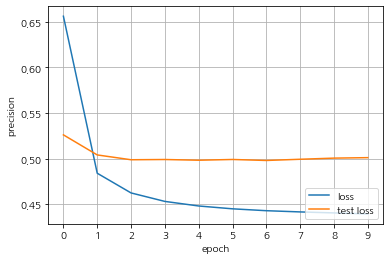

In [114]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='test loss')
plt.xticks(range(len(hist.history['loss'])))
plt.xlabel('epoch')
plt.ylabel('precision')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
# valid loss가 올라가는 순간 train data에 overfitting 
# epoch 중에 2,3 번까지만 하는 것이 가장 학습이 잘 되는 것으로 보임 -> epoch:20 -> epoch:3

In [115]:
pred_dl_prob = model.predict(test_X_dl)
pred_dl = np.argmax(pred_dl_prob, axis=1)

pred_dl

array([30, 16, 20, ...,  5, 24, 15], dtype=int64)

# 7. Evaluation
- precision(정밀도) : True -> True 
- Recall(재현율) : True인 것을 맞춘 비율 
- F1 score : precision 과 recall의 조화평균

In [38]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

def show_pred(test_y, pred) :
    true_y = test_y.to_numpy()
    true_y = np.ravel(true_y)
    
    df_result = pd.DataFrame(list(zip(true_y, pred)), columns=['true_y', 'prediction'])
    return df_result
    
def show_prediction_error(test_y, pred) :
    true_y = test_y.to_numpy()
    true_y = np.ravel(true_y)
    error = pred - true_y
    plt.hist(error, bins=25)
    plt.xlabel("Prediction Error")
    _ = plt.ylabel("Count")
    
def feature_importance(model_xgb) : 
    %matplotlib inline
    plt.rcParams['axes.unicode_minus'] = False
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = fm.FontProperties(fname=font_path).get_name()
    rc('font', family=font)

    fig, ax = plt.subplots(figsize=(10,12))
    plot_importance(model_xgb, ax=ax)
    
def graph(pred, test_label) :
    plt.figure(figsize=(16, 9))
    plt.plot(test_label, label = 'actual')
    plt.plot(pred, label = 'prediction')
    plt.legend()
    plt.show()

def classification_report_csv(report) : 
    df = pd.DataFrame(report).transpose()
    df.to_csv('classfication_report.csv', index=False)

In [39]:
# DL model 
print(classification_report(test_y, pred_dl)) # word embedding 

NameError: name 'pred_dl' is not defined

In [40]:
# ML model
#report = classification_report(test_y, pred_xgb, output_dict=True)
print(classification_report(test_y, pred_xgb))
#classification_report_csv(report)

              precision    recall  f1-score   support

           0       0.77      0.18      0.29     22760
           1       1.00      1.00      1.00         2
           2       0.61      0.36      0.45      4910
           3       0.68      0.07      0.12     15917
           4       0.62      0.18      0.27      9413
           5       0.63      0.31      0.42     12738
           6       0.80      0.80      0.80         5
           7       0.56      0.21      0.31      6527
           8       0.62      0.30      0.40     27195
           9       0.56      0.14      0.23     10681
          10       0.63      0.37      0.46       686
          11       0.59      0.98      0.73     45519
          12       0.58      0.46      0.51      1245
          13       0.50      0.50      0.50         2
          14       0.58      0.29      0.38      5621
          15       0.64      0.70      0.67     17952
          16       0.55      0.98      0.71     31834
          17       0.58    

In [41]:
# ML model
#report = classification_report(test_y, pred_lgbm, output_dict=True)
print(classification_report(test_y, pred_lgbm))
#classification_report_csv(report)

C:\Users\mtang\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.36      0.03      0.05     22760
           1       0.00      0.00      0.00         2
           2       0.04      0.01      0.02      4910
           3       0.00      0.00      0.00     15917
           4       0.52      0.03      0.05      9413
           5       0.00      0.00      0.00     12738
           6       0.00      0.00      0.00         5
           7       0.16      0.00      0.00      6527
           8       0.06      0.96      0.12     27195
           9       0.00      0.00      0.00     10681
          10       0.00      0.00      0.00       686
          11       0.22      0.00      0.01     45519
          12       0.00      0.00      0.00      1245
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00      5621
          15       0.64      0.00      0.00     17952
          16       0.33      0.06      0.11     31834
          17       0.00    

C:\Users\mtang\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mtang\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
feature_series = pd.Series(data=model_xgb.feature_importances_, index=train_X.columns)
feature_series = feature_series.sort_values(ascending=False) 
sns.barplot(x = feature_series, y=feature_series.index)

ValueError: Length of passed values is 14, index implies 17.

# 8. Ensemble


In [121]:
pred_ensemble_prob = pred_xgb_prob * 0.5 + pred_dl_prob * 0.5
pred_ensemble = np.argmax(pred_ensemble_prob, axis=1)
pred_ensemble

array([30, 24, 20, ...,  5, 24, 15], dtype=int64)

In [122]:
print(classification_report(test_y, pred_ensemble))

              precision    recall  f1-score   support

           0       0.85      0.58      0.69     22760
           1       1.00      1.00      1.00         2
           2       0.84      0.77      0.81      4910
           3       0.90      0.65      0.76     15917
           4       0.86      0.69      0.77      9413
           5       0.86      0.65      0.74     12738
           6       0.67      0.80      0.73         5
           7       0.89      0.61      0.73      6527
           8       0.83      0.73      0.77     27195
           9       0.86      0.57      0.69     10681
          10       0.82      0.76      0.79       686
          11       0.72      0.92      0.81     45519
          12       0.82      0.74      0.78      1245
          13       0.00      0.00      0.00         2
          14       0.86      0.84      0.85     23573
          15       0.74      0.94      0.83     31834
          16       0.87      0.64      0.74      4174
          17       0.85    